In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from fastai.vision.all import *
from torchvision import transforms
import torchvision.transforms.functional as TF
import ipywidgets as widgets
from PIL import Image as pilImage
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
ROOT_DIR =  Path('../')
DATA_PATH = ROOT_DIR/'data/'
IMGS_PATH = ROOT_DIR/'imgs/'

In [3]:
path = untar_data(URLs.IMAGENETTE_160,dest=DATA_PATH)
path

Path('../data/imagenette2-160')

In [4]:
(path/'train').ls()

(#10) [Path('../data/imagenette2-160/train/n03394916'),Path('../data/imagenette2-160/train/n03417042'),Path('../data/imagenette2-160/train/n03445777'),Path('../data/imagenette2-160/train/n02102040'),Path('../data/imagenette2-160/train/n03425413'),Path('../data/imagenette2-160/train/n03888257'),Path('../data/imagenette2-160/train/n03028079'),Path('../data/imagenette2-160/train/n03000684'),Path('../data/imagenette2-160/train/n01440764'),Path('../data/imagenette2-160/train/n02979186')]

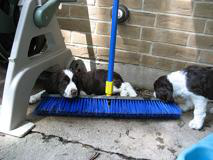

In [371]:
fname = (path/"train/n02102040").ls()[18]
PILImage.create(fname)

In [6]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)
#eval() is very important, otherwise the results are not useable 
#(I don't understand why train mode computes almost always the same results, no matter what's the input img)
model = model.eval() 

Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0


In [7]:
import urllib.request, json 
with urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json') as url:
    classes = json.loads(url.read().decode())
f_to_idx = {val[0]:idx for idx,val in classes.items()}
my_classes = [f_to_idx[f.name] for f in (path/"train").ls()]


In [65]:
#def np_to_tensor(array):
#    return torch.Tensor(array).permute(2,0,1).float()
#def img_to_tensor(img):
#    return transforms.ToTensor()(img)
def tensor_to_img(img):
    #assert 0
    return (img.permute(1,2,0).numpy()*255.).astype('uint8')

def imresize(arr, sz):
    height, width = sz
    return np.array(arr_to_img(arr).resize((width, height), resample=pilImage.BILINEAR))

def arr_to_img(img, cmap=None):
    def normalize(x): 
        return (x-x.min())/(x.max()-x.min())
    if cmap is not None:
        cm = plt.get_cmap(cmap)
        img = cm(img)[:,:,:3]
    return PILImage.create((normalize(img)*255).astype('uint8'))

# Show linear layer activation function
def show_1D_act(act):
    '''Show activation visualizations of the l-th linear layer with figsize s*s'''
    act_length = act.shape[-1]
    act = act.numpy() if type(act)!=np.ndarray else act
    act = np.array([[act],]*20).reshape(20,act.shape[-1]) # copy linear activation 20x for better visualization
    act = arr_to_img(imresize(act, (20,400)))
    #act = arr_to_img(act).resize((20,5),resample=pilImage.BILINEAR)
    fig, ax = plt.subplots(figsize=(10,1))
    ax.imshow(act, cmap='inferno')
    ax.set_axis_off()

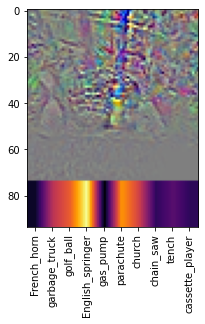

In [372]:
class MyImg():
    def __init__(self,img,model=None,get_model_act=False,restrict_classes=None):
        self.img_orig = img.copy()
        self.img = img.copy()
        self.x_orig = transforms.ToTensor()(img).unsqueeze(0)
        self.x = transforms.ToTensor()(img).unsqueeze(0)
        self.model = model
        self.get_model_act = get_model_act
        self.images = []
        self.activations = []
        self.restrict_classes = restrict_classes
        self.class_idx = [int(i) for i in restrict_classes.keys()] if restrict_classes is not None else None
        
    def reset(self):
        self.img = self.img_orig.copy()
        self.x = self.x_orig # does this work without some kind of copy ? in tfms() it seems to work
        self.images = []
        self.activations = []
        
    def tfm_brightness(self, brightness):
        x =  TF.adjust_brightness(self.x, brightness)
        return x
    
    def tfm_centercrop(self, crop_size):
        x =  transforms.CenterCrop(crop_size)(self.x)
        return x  
    
    def tfms(self, brightness=None, crop_size=None, show=True):
        self.x = self.x_orig#.copy()
        if brightness is not None:
            self.x = self.tfm_brightness(brightness)
        if crop_size is not None:
            self.x = self.tfm_centercrop(crop_size)
        
        if self.get_model_act:
            out = self.model(normalize(self.x)).detach().numpy()
            if self.restrict_classes is not None:
                out = out[:,self.class_idx]
            self.activations.append(out)
            img = self.combine_activation_with_img(out)
        else:
            img = transforms.ToPILImage()(self.x[0])
        self.images.append(img)
        if show:
            #display(pilImage.fromarray(img).to_thumb(512,512))
            fig,ax = plt.subplots()
            
            try:
                my_xticks = self.restrict_classes.values()
                nr_classes = len(self.restrict_classes)
                h,w,d = img.shape
                step_size = w/nr_classes
                #plt.xticks(np.arange(nr_classes)*step_size+(step_size//2), my_xticks,rotation=90)
                ax.set_xticks(np.arange(nr_classes)*step_size+(step_size//2))
                ax.set_xticklabels(my_xticks,rotation=90)
                
            except Exception:
                #print((h,w,d),step_size,(step_size//2,(w-step_size//2+1)))
                #print(np.arange(nr_classes)*step_size+(step_size//2))     
                pass
            ax.imshow(img)
    
    def combine_activation_with_img(self, out):
        # to make flatten activation better visible, the images will be streched by a factor of 20 
        # and the width is adapted to the original image width
        shape = (20,self.x.shape[2])
        transform_act = lambda x: arr_to_img(imresize(x,shape), 'inferno') 
        #transform_act = lambda x: arr_to_img(x).resize(shape),resample=pilImage.BILINEAR)

        # combine transformed images and their layer activations
        #img_comb = np.vstack([tensor_to_img(self.x[0]), transform_act(out) ])
        #img_comb = np.vstack([tensor_to_img(cam_gb), transform_act(out) ])
        heatmap, gb, cam_gb = find_relevant_input(normalize(self.x).requires_grad_(True))
        img_comb = np.vstack([cam_gb, transform_act(out) ])
        return img_comb
    
    def create_gif(self,path): 
        # to make flatten activation better visible, the images will be streched by a factor of 20 and the width is adapted to the original image width
        w,h,d = self.images[0].shape
        transform_act = lambda x: arr_to_img(imresize(x,(20,w)), 'inferno') 

        # combine sequence of transformed images and their layer activations
        imgs_combs = [ np.vstack([arr_to_img(img).resize((w,h)), transform_act(act) ]) for img, act in zip(self.images,self.activations)  ]

        # transform to images, add backward loop and store as gif
        first_img, *imgs = [ pilImage.fromarray( img ) for img in imgs_combs]
        imgs += [img for img in imgs[::-1]]
        first_img.save(fp=path, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)

        
# todo: pass as argument
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
size = 160
img = PILImage.create(fname).resize((size,size))
myimg = MyImg(img,
              model,
              get_model_act=True,
              restrict_classes={i:classes[i][1] for i in my_classes})
myimg.tfms(crop_size=74)

In [373]:
import ipywidgets as widgets
def create_gif_on_click(change):
    myimg.create_gif(IMGS_PATH/'test2.gif')

btn_create_gif = widgets.Button(description='Create gif')
btn_create_gif.on_click(create_gif_on_click)

slider_brightness = widgets.FloatSlider(value=1,min=0.1,max=4,stepsize=0.2)
slider_crop_size = widgets.IntSlider(value=100,min=33,max=160,stepsize=5)
out_tfms = widgets.interactive_output(myimg.tfms, {"brightness":slider_brightness,"crop_size":slider_crop_size})

In [374]:
myimg.reset()
#out_tfms.clear_output()
widgets.HBox([widgets.VBox([slider_brightness,slider_crop_size,btn_create_gif]), out_tfms])

[SegmentLocal](../imgs/test2.gif "segment")


[SegmentLocal](../imgs/test.gif "segment")
[SegmentLocal](../imgs/results/test.gif "segment")


In [38]:
# to save the images separate 
#os.makedirs('../imgs/img_list/',exist_ok=True)
#os.makedirs('../imgs/results/',exist_ok=True)
#
#for i,pic in enumerate(imgs):
#    pic.save(fp=f'../imgs/img_list/img_{str(i).zfill(2)}.png', format='PNG')

# to use ffmpeg I need to deactivate conda and call this in the terminal
# but it doesn't seem for me that the results are better, so I leave it for now
#ffmpeg -f image2 -i imgs/img_list/img_%02d.png -vf scale=2480:-1:sws_dither=ed,palettegen imgs/results/palette.png -y
#ffmpeg -f image2 -framerate 10. -i imgs/img_list/img_%02d.png imgs/results/img.flv -y
#ffmpeg -i imgs/results/img.flv -i imgs/results/palette.png -filter_complex "fps=10,scale=248:-1:flags=lanczos[x];[x][1:v]paletteuse" imgs/results/test.gif -y
#ffmpeg -i imgs/results/img.flv -i imgs/results/palette.png -filter_complex "fps=10,scale=248:-1:flags=lanczos[x];[x][1:v]paletteuse" -loop -1 imgs/results/test_no_loop.gif -y


In [97]:
#import argparse
#import cv2
#import numpy as np
import torch
from torch.autograd import Function
from torchvision import models

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input


def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))


class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        #cam = cv2.resize(cam, input.shape[2:])
        cam = imresize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(Function):

    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply
                
        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument('--image-path', type=str, default='./examples/both.png',
                        help='Input image path')
    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print("Using GPU for acceleration")
    else:
        print("Using CPU for computation")

    return args

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)





In [160]:
??preprocess_image

Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0


In [352]:
#todo: find a way to pass model (it gets overwritten somewhere and the same code can't be used twice without loading it again)
grad_cam = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
gb_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)

grad_cam = GradCam(model=grad_cam, feature_module=grad_cam.layer4, \
                   target_layer_names=["2"], use_cuda=use_cuda)
gb_model = GuidedBackpropReLUModel(model=gb_model, use_cuda=use_cuda)



Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0


In [362]:
def find_relevant_input(x, target_index = None):
    # If target_index is None, returns the map for the highest scoring category.
    # Otherwise, targets the requested index.
    mask = grad_cam(x, target_index)
    heatmap = arr_to_img(mask,cmap='inferno')
    #cam = np.float32(img)+np.float32(heatmap)

    #print(model._modules.items())
    gb = gb_model(x, index=target_index)
    mask = grad_cam(x, target_index)

    gb = gb.transpose((1, 2, 0))
    cam_mask = np.stack([mask, mask, mask],2)
    cam_gb = deprocess_image(cam_mask*gb)
    gb = deprocess_image(gb)
    return heatmap, gb, cam_gb
heatmap, gb, cam_gb = find_relevant_input(x.requires_grad_(True))

In [345]:
%%timeit
heatmap, gb, cam_gb = find_relevant_input(x.requires_grad_(True))

753 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [208]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)
model.eval()

Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [363]:
size=160
fname = (path/"train/n02102040").ls()[2]
#input = preprocess_image(np.float32(img))
#pred = model(normalize(input)).argmax()
img = PILImage.create(fname).resize((size,size))
x = normalize(transforms.ToTensor()(img)).unsqueeze(0)
with torch.no_grad():
    pred = model(x).argmax()
print(classes[str(pred.numpy())][1])

heatmap, gb, cam_gb = find_relevant_input(x.requires_grad_(True))
cam = np.float32(img)+np.float32(heatmap)

English_springer


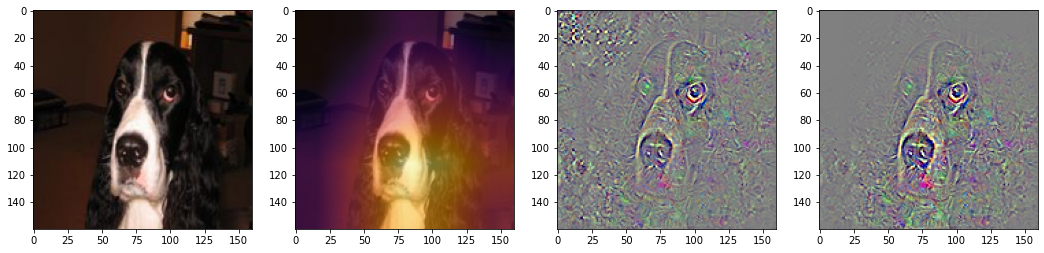

In [364]:
fig, ax = plt.subplots(1,4,figsize=(18,6))
ax[0].imshow(img)
ax[1].imshow(arr_to_img(cam))
ax[2].imshow(gb)
ax[3].imshow(cam_gb)
plt.show()

In [78]:
device = 'cpu'
use_cuda = True if device == 'cuda' else False

In [81]:
img.shape

(160, 160)

In [86]:
imresize(img,(30,30))

AttributeError: 'Image' object has no attribute 'min'

In [99]:
#model = models.resnet50(pretrained=True)
grad_cam = GradCam(model=model, feature_module=model.layer4, \
                   target_layer_names=["2"], use_cuda=use_cuda)

#img = cv2.imread(args.image_path, 1)
#img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(np.float32(img))

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None
mask = grad_cam(input, target_index)

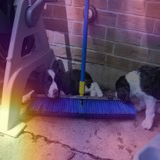

In [146]:
mask = grad_cam(input,None)
heatmap = arr_to_img(mask,cmap='inferno')
cam = np.float32(img)+np.float32(heatmap)
arr_to_img(cam)

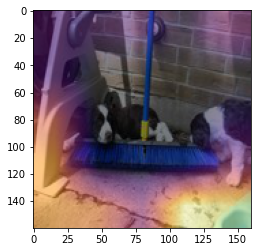

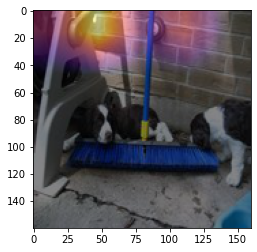

<ipython-input-65-9497eabb58a3>:15: RuntimeWarning: invalid value encountered in true_divide
  return (x-x.min())/(x.max()-x.min())
<ipython-input-97-54503c22bed6>:133: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / np.max(cam)


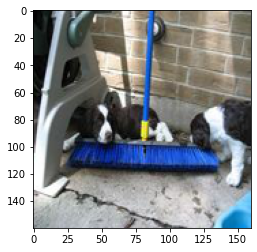

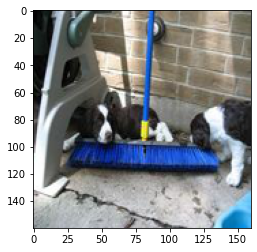

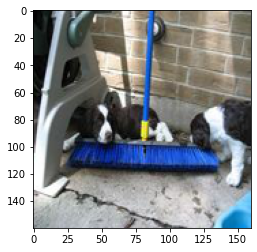

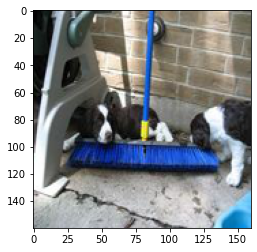

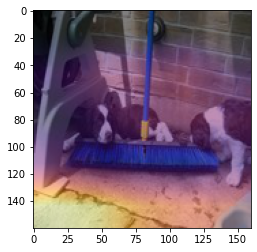

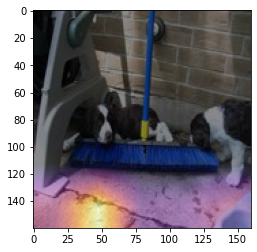

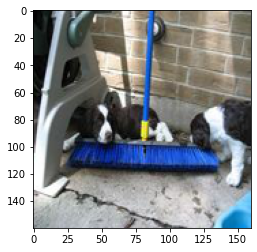

In [144]:
for i in range(1,10):
    mask = grad_cam(input,i)
    heatmap = arr_to_img(mask,cmap='inferno')
    cam = np.float32(img)+np.float32(heatmap)
    plt.imshow(arr_to_img(cam))
    plt.show()

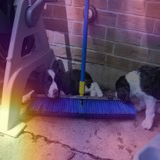

In [103]:
img+arr_to_img(mask,cmap='inferno')

TypeError: unsupported operand type(s) for +: 'Image' and 'PILImage'

In [ ]:
def arr_to_img(img, cmap=None):
    def normalize(x): 
        return (x-x.min())/(x.max()-x.min())
    if cmap is not None:
        cm = plt.get_cmap(cmap)
        img = cm(img)[:,:,:3]
    return PILImage.create((normalize(img)*255).astype('uint8'))


In [ ]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))